# Customer DNA Olist : Construction d’une Segmentation Actionnable et Durable

## Étape 1- Objectifs business et cadrage
**Comprendre et traduire les besoins de l’équipe e-commerce :**
- Identifier différents profils clients
- Fournir une segmentation actionnable pour les campagnes marketing
- Déterminer une fréquence optimale de mise à jour
- Proposer un contrat de maintenance basé sur la stabilité des segments
- Définir les usages marketing :
- Personnalisation emails
- Relance clients à risque
- Cross-selling / upselling
- Détection des VIP
- Activation produit selon catégories
## Étape 2- Construction d’une base client à partir de différentes sources Olist

**Fusion intelligente de toutes les sources Olist :**
- Clients
- Commandes
- Articles des commandes
- Paiements
- Produits et catégories
- Avis
- Localisation
**Objectif : obtenir un Customer Master Table (CMT).**

## Étape 3- Data cleaning & qualité
- Harmonisation des types (dates, flottants, catégoriels)
- Détection et filtrage des commandes annulées
- Gestion des doublons (customer_id vs customer_unique_id)
- Imputation robuste des valeurs manquantes
- Correction des incohérences de dates (livraison < achat, etc.)

## Étape 4 — Feature engineering avancé
**Comportement d’achat**
- RFM (Recency, Frequency, Monetary)
- Panier moyen
- Valeur vie client (CLV proxy)
- Répétition d’achat
- Nombre de catégories différentes

**Logistique**
- Temps de livraison réel vs estimé
- Variabilité des délais
- Coût moyen du transport

**Qualité / Satisfaction**
- Scores moyens
- Probabilité d’insatisfaction
- Sentiment NLP simplifié des commentaires

**Géographie**
- Distance vendeur–client (si géoloc exploitée)
- Région

## Étape 5 — Segmentation non supervisée

**Méthodes testées dans ton notebook :**

- K-means
- GMM
- Agglomerative clustering
- DBSCAN (pour bruit ou anomalies)
- PCA / UMAP pour réduction de dimensions

**Critères d’évaluation : silhouette score, cohérence business, interprétabilité.**

## Étape 6 — Analyse et description des personas
- Pour chaque segment :
- Profil démographique
- Comportement d’achat
- Valeur économique
- Satisfaction
- Recommandations marketing actionnables
- “Do & Don’t” marketing

## Étape 7 — Analyse de stabilité dans le temps
- Notebook dédié pour :
- Mesurer la dérive des segments (Population Stability Index – PSI)
- Tester un glissement temporel (rolling windows mensuelles)
- Estimer la fréquence optimale de mise à jour (ex : trimestrielle)

## Étape 8 — Proposition de contrat de maintenance
- Livrables marketing + techniques :
- Mise à jour des segments X fois par an
- Monitoring automatique
- Dashboard BI
- Document d’interprétation marketing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [2]:
# Chargement des données
def load_csv(filename):
    return pd.read_csv(f"/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/{filename}", low_memory=False)

customers      = load_csv("olist_customers_dataset.csv")
geoloc         = load_csv("olist_geolocation_dataset.csv")
orders         = load_csv("olist_orders_dataset.csv")
order_items    = load_csv("olist_order_items_dataset.csv")
payments       = load_csv("olist_order_payments_dataset.csv")
reviews        = load_csv("olist_order_reviews_dataset.csv")
products       = load_csv("olist_products_dataset.csv")
sellers        = load_csv("olist_sellers_dataset.csv")
categories     = load_csv("product_category_name_translation.csv")

# Prétraitement minimal

## Convertir les dates en datetime
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_creation_date",
    "review_answer_timestamp"
]

for col in date_cols:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors='coerce')
    if col in reviews.columns:
        reviews[col] = pd.to_datetime(reviews[col], errors='coerce')

# Ne garder que les commandes livrées
orders = orders[orders["order_status"] == "delivered"]

# Fusion produits + catégories

products = products.merge(categories,
                          on="product_category_name",
                          how="left")

# Fusion des fichiers csv

# order_items + orders
df = order_items.merge(orders,
                       on="order_id",
                       how="inner")

# + reviews
df = df.merge(reviews,
              on="order_id",
              how="left")

# + customers
df = df.merge(customers,
              on="customer_id",
              how="left")

# + products
df = df.merge(products,
              on="product_id",
              how="left")

# + payments
df = df.merge(payments,
              on="order_id",
              how="left")

# Nettoyage final

# Supprimer les doublons
df.drop_duplicates(inplace=True)

# Uniformisation des noms de colonnes
df.columns = df.columns.str.lower().str.strip()

# Imputation basique
df["review_comment_message"] = df["review_comment_message"].fillna("")
df["review_comment_title"]   = df["review_comment_title"].fillna("")

# Export final
df.to_csv("/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/olist_dataset.csv", index=False)

print("Fusion terminée — Base finale :", df.shape)


Fusion terminée — Base finale : (115723, 37)


In [3]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,97ca439bc427b48bc1cd7177abe71365,5.0,,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,7b07bacd811c4117b742569b04ce3580,4.0,,,2017-05-13,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,0c5b33dea94867d1ac402749e5438e8b,5.0,,Chegou antes do prazo previsto e o produto sur...,2018-01-23,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,f4028d019cb58564807486a6aaf33817,4.0,,,2018-08-15,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,940144190dcba6351888cafa43f3a3a5,5.0,,Gostei pois veio no prazo determinado .,2017-03-02,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,1.0,credit_card,3.0,218.04


# Analyse exploratoire

In [4]:
# Stricture des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115723 entries, 0 to 115722
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115723 non-null  object        
 1   order_item_id                  115723 non-null  int64         
 2   product_id                     115723 non-null  object        
 3   seller_id                      115723 non-null  object        
 4   shipping_limit_date            115723 non-null  object        
 5   price                          115723 non-null  float64       
 6   freight_value                  115723 non-null  float64       
 7   customer_id                    115723 non-null  object        
 8   order_status                   115723 non-null  object        
 9   order_purchase_timestamp       115723 non-null  datetime64[ns]
 10  order_approved_at              115708 non-null  datetime64[ns]
 11  

In [5]:
# Nature des données
df.dtypes.value_counts()

object            15
float64           13
datetime64[ns]     7
int64              2
Name: count, dtype: int64

In [6]:
# Statistioques descriptives
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
order_id,115723,96478,895ab968e7bb0d5659d16cd74cd1650c,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,115723.0,NaN,NaN,NaN,1.197048,1.0,1.0,1.0,1.0,21.0,0.701221
product_id,115723,32216,aca2eb7d00ea1a7b8ebd4e68314663af,529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,115723,2970,4a3ca9315b744ce9f8e9374361493884,2116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipping_limit_date,115723,91344,2017-08-14 20:43:31,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,115723.0,NaN,NaN,NaN,119.911096,0.85,39.9,74.9,132.9,6735.0,182.670252
freight_value,115723.0,NaN,NaN,NaN,19.9814,0.0,13.08,16.28,21.16,409.68,15.71829
customer_id,115723,96478,270c23a11d024a44c896d1894b261a83,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,115723,1,delivered,115723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,115723,NaN,NaN,NaN,2017-12-31 09:55:44.254227712,2016-09-15 12:16:38,2017-09-12 18:16:08,2018-01-18 21:40:03,2018-05-04 10:29:14,2018-08-29 15:00:37,NaN


In [7]:
# Analyse des valeurs manquantes
def showall_missing(df):
    return (df.isna().sum()/df.shape[0]).sort_values(ascending=True)*100

showall_missing(df)

order_id                         0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_estimated_delivery_date    0.000000
customer_city                    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
review_comment_message           0.000000
review_comment_title             0.000000
customer_state                   0.000000
order_delivered_carrier_date     0.001728
payment_type                     0.002592
payment_sequential               0.002592
payment_value                    0.002592
payment_installments             0.002592
order_delivered_customer_date    0.006913
order_approved_at                0

Le jeux de données est rempli à 99.73%
et il a 0.27% de données manquantes
 
 


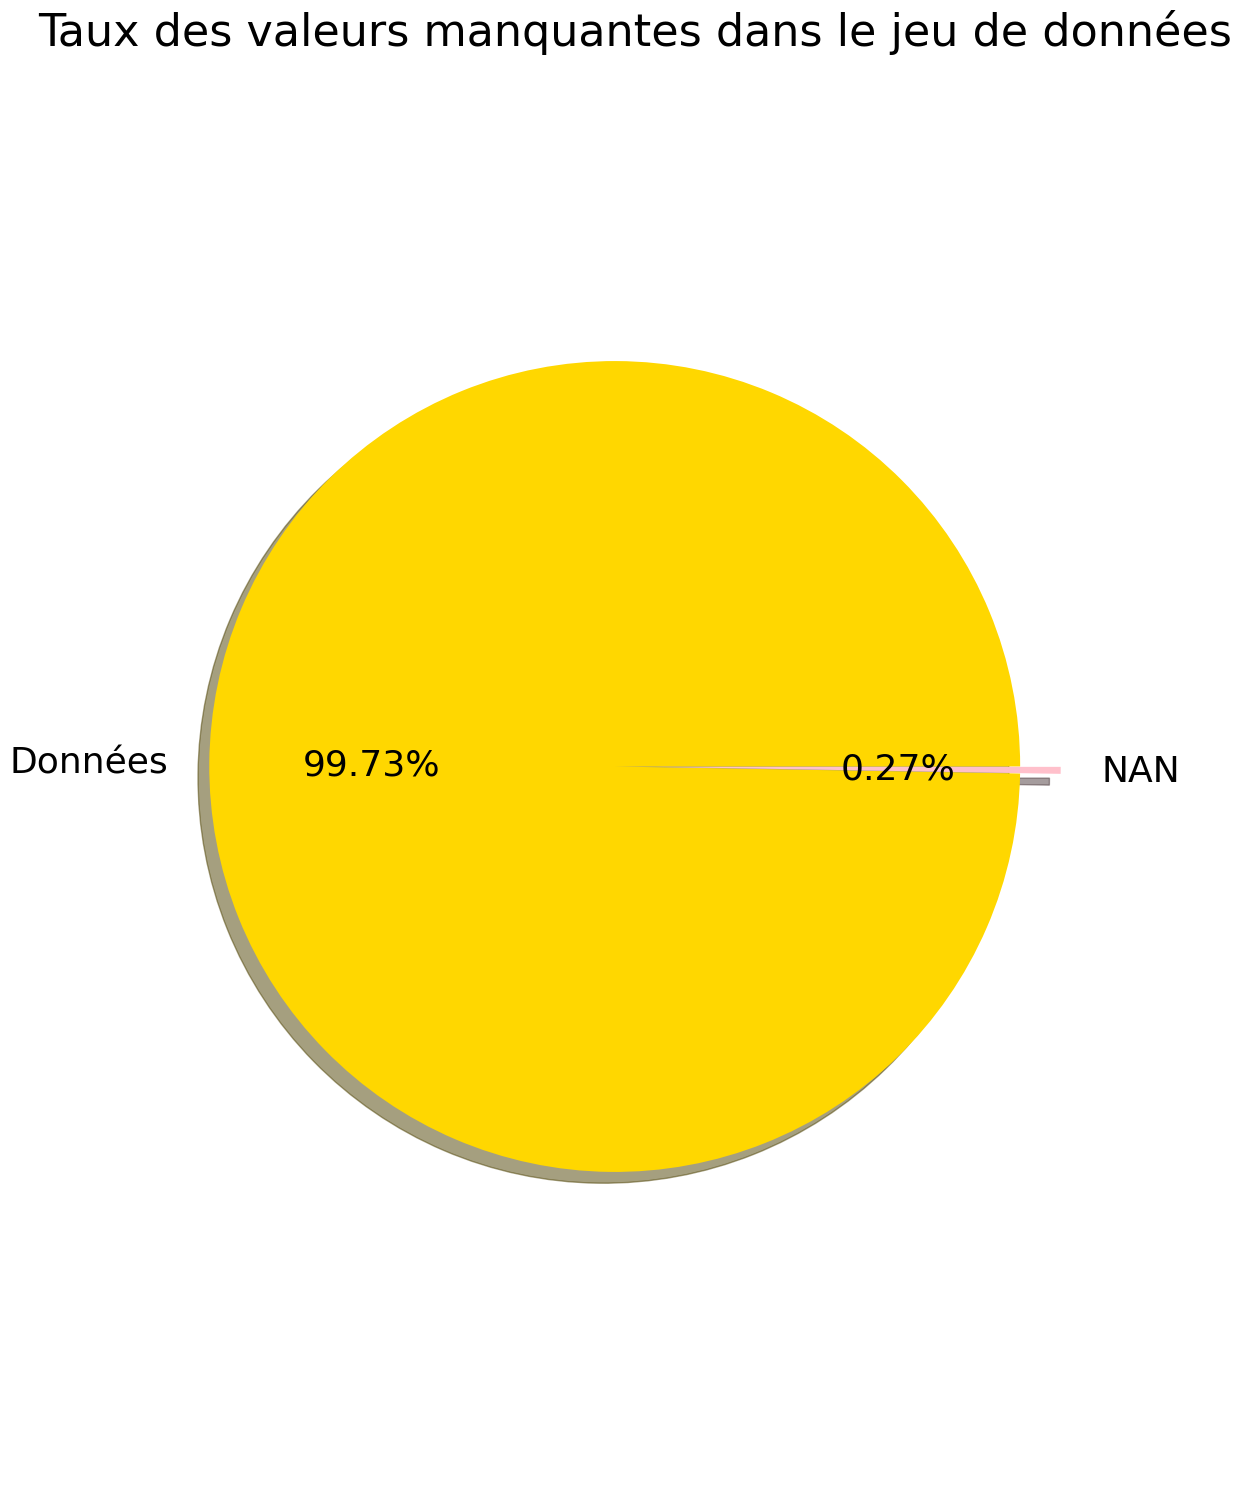

In [8]:
def pie_NaN(dataframe):

    lignes = dataframe.shape[0] 
    colonnes = dataframe.shape[1]

  # nombre de données non manquante
    nb_data = dataframe.count().sum()

  # nombre de données totale de ce jeu de données (colonnes*lignes)
    nb_totale = (colonnes*lignes)

  #taux remplissage jeu de données
    rate_dataOK = (nb_data/nb_totale)
    print("Le jeux de données est rempli à {:.2%}".format(rate_dataOK))
    print("et il a {:.2%} de données manquantes".format(1-rate_dataOK))
    print(" ")
    print(" ")
    
     # Pie Plot
    rates = [rate_dataOK, 1 - rate_dataOK]
    labels = ["Données", "NAN"]

    explode =(0,0.1) 
    colors = ['gold', 'pink']

  # Plot
    plt.figure(figsize=(12,15))
    plt.pie(rates, explode=explode, labels=labels, colors=colors, autopct='%.2f%%', shadow=True, textprops={'fontsize': 26})

    ttl=plt.title("Taux des valeurs manquantes dans le jeu de données", fontsize = 32)
    ttl.set_position([0.5, 0.50])

    plt.axis('equal')
  #ax.legend(labels, loc = "upper right", fontsize = 18)
    plt.tight_layout() 

    plt.show() 

pie_NaN(df)

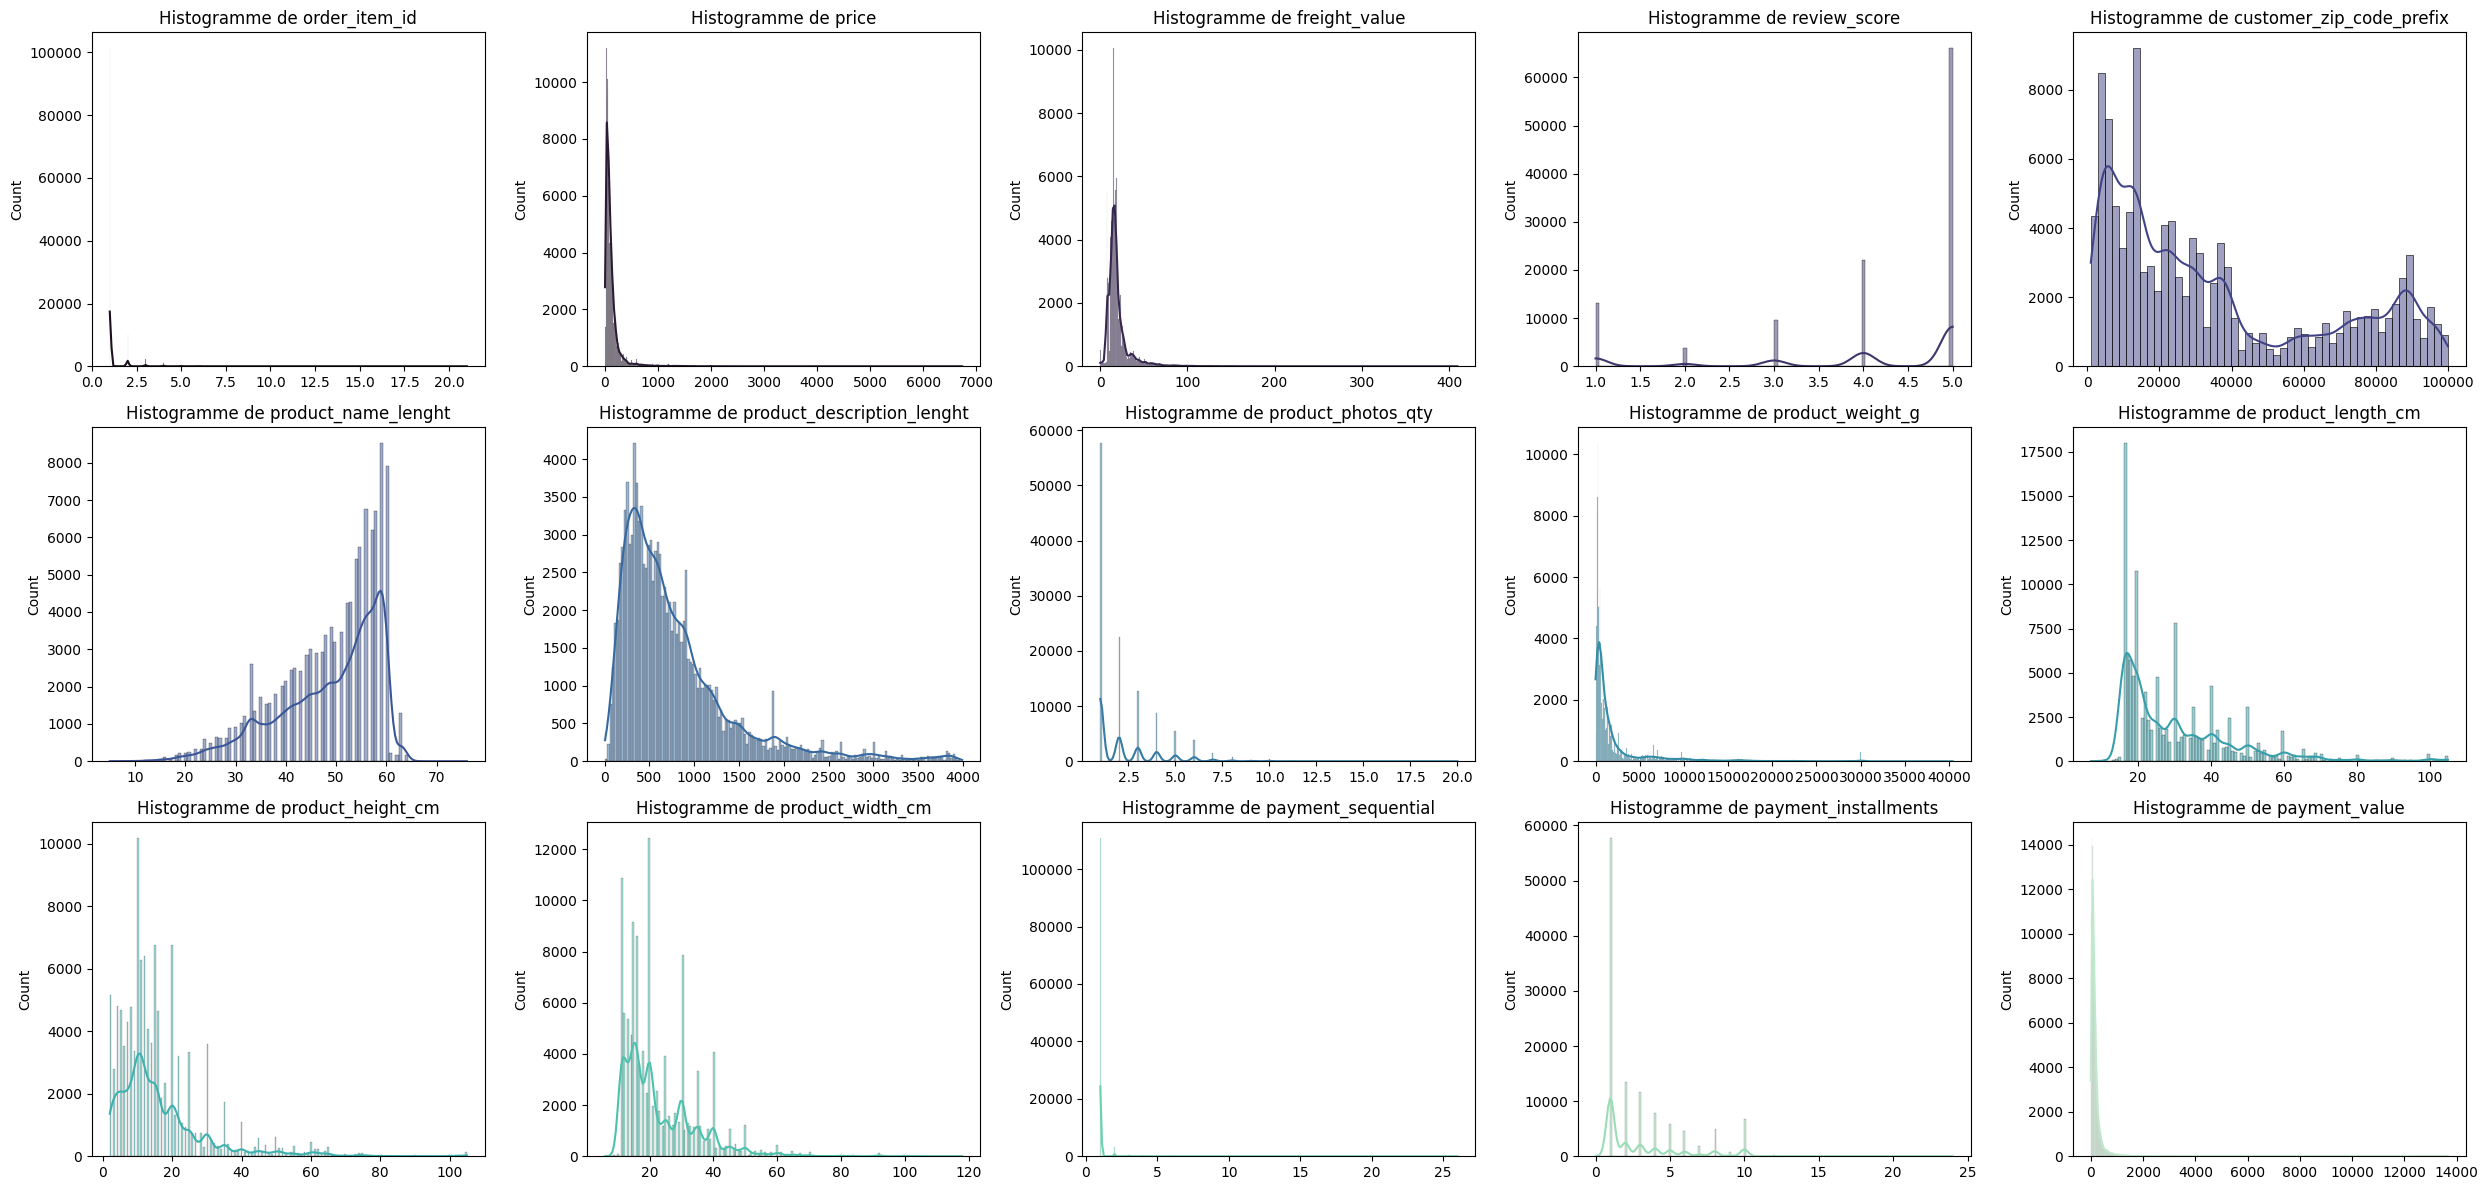

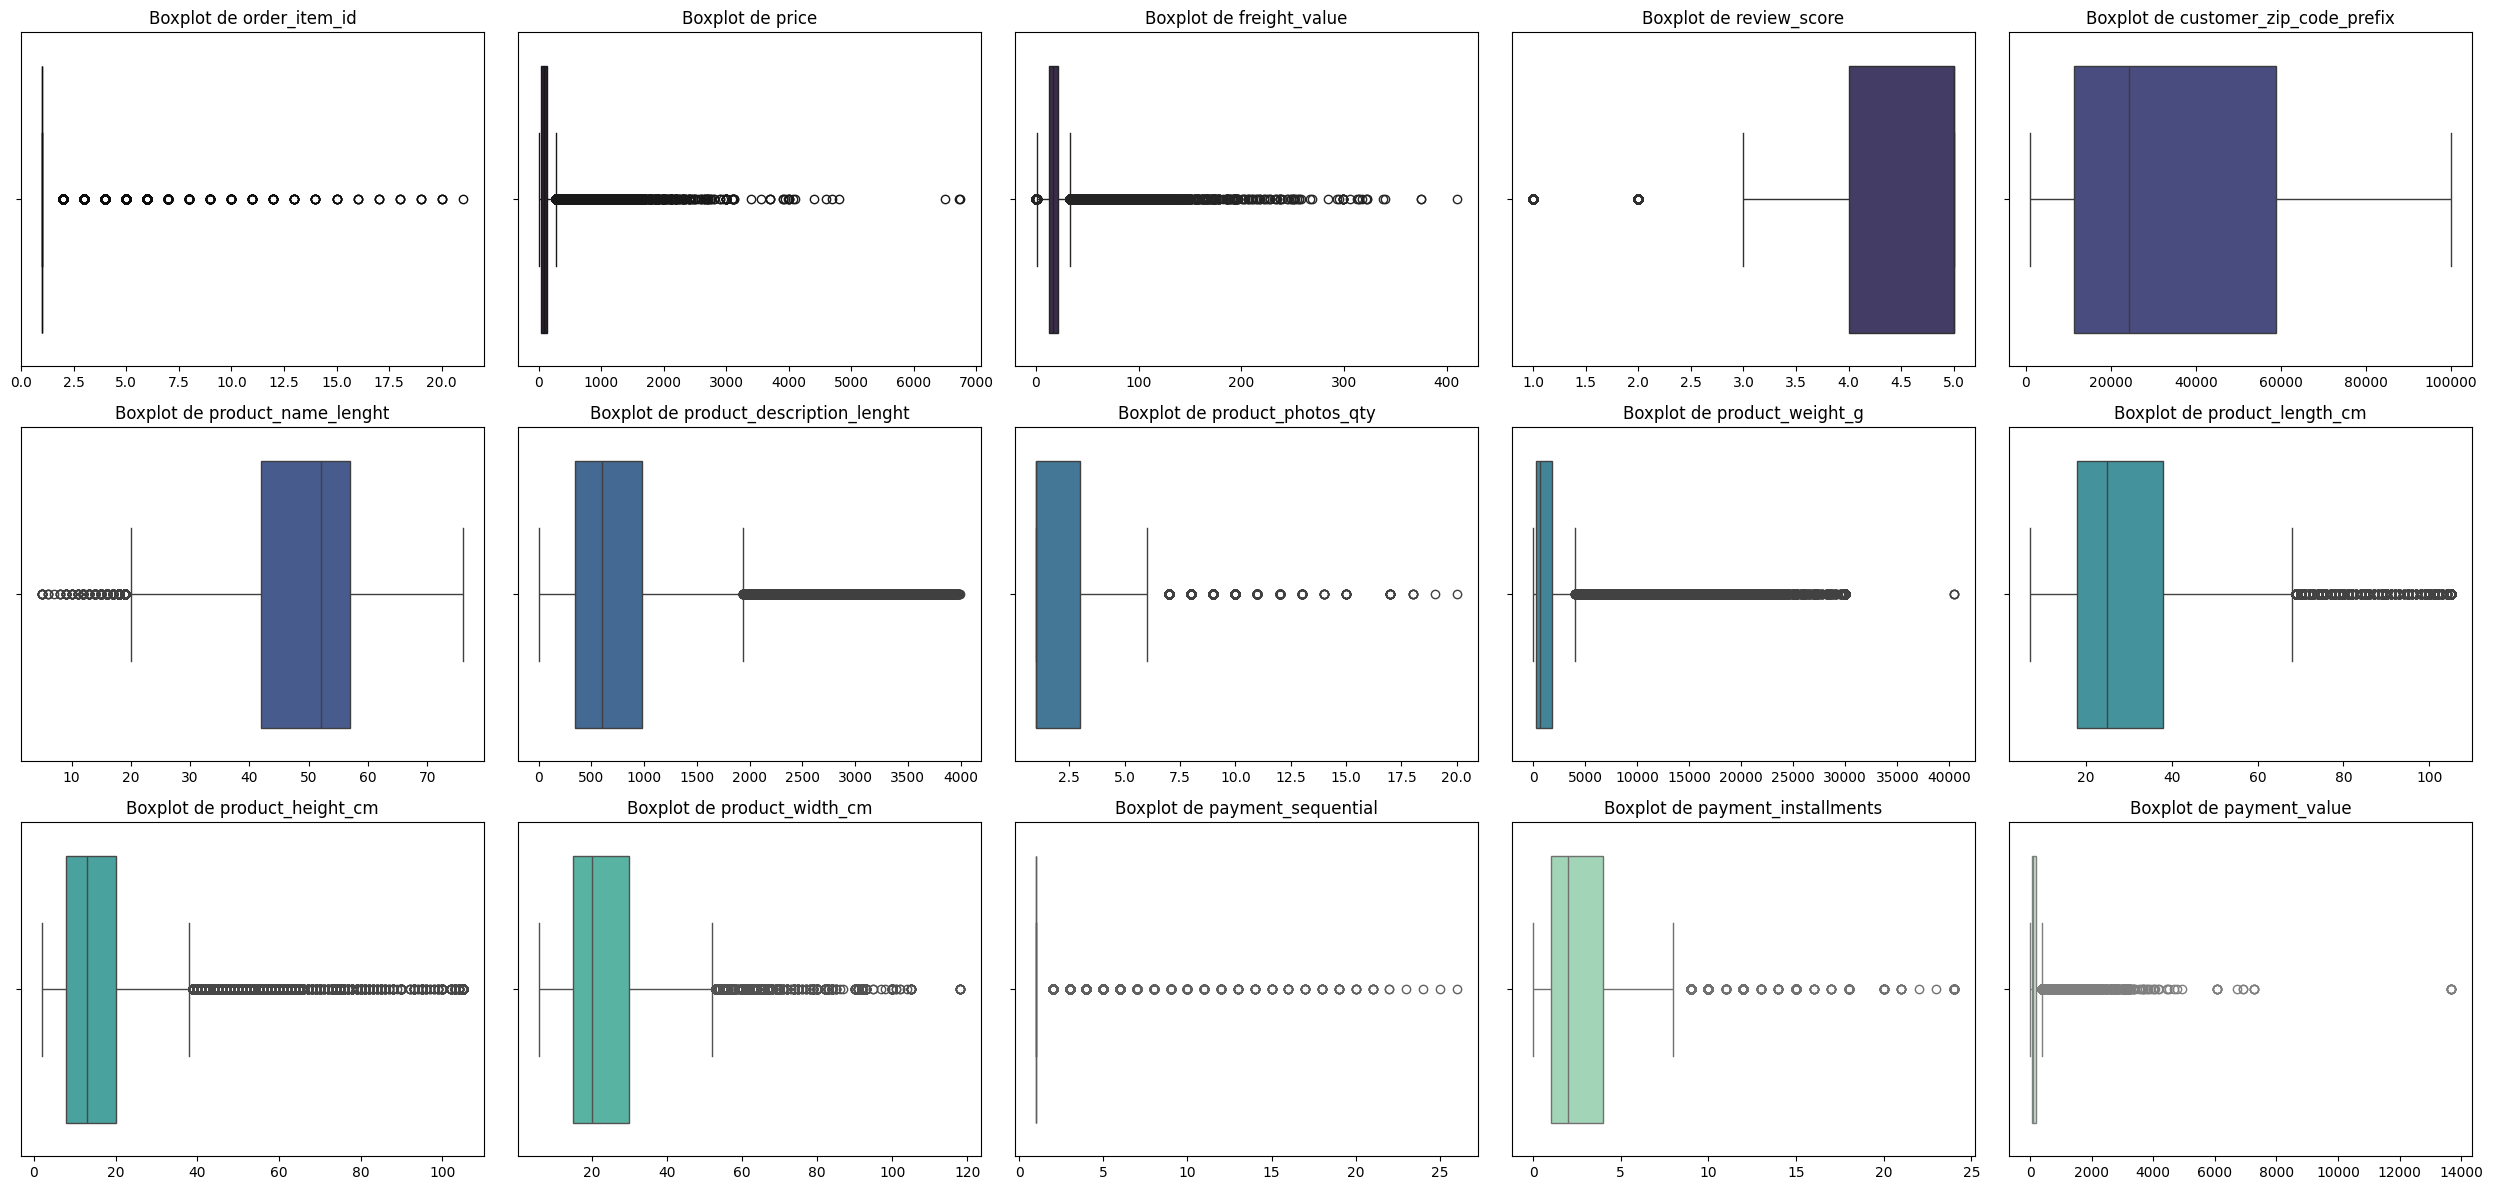

In [9]:
def plot_numeric_distributions(df, nrows=3, palette="crest"):
    """
    Affiche les histogrammes et boxplots de toutes les variables numériques
    avec une palette automatique (chaque variable a sa propre couleur).
    """

    # Sélection des variables numériques
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    n_features = len(numeric_cols)

    if n_features == 0:
        print("Aucune variable numérique à afficher.")
        return

    # Palette automatique
    colors = sns.color_palette(palette, n_features)

    # Nombre de colonnes
    ncols = int(np.ceil(n_features / nrows))

    # ---------------------------
    #     HISTOGRAMMES
    # ---------------------------
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), ax=axes[i], color=colors[i], kde=True)
        axes[i].set_title(f'Histogramme de {col}', fontsize=12)
        axes[i].set_xlabel("")
    
    for ax in axes[n_features:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

    # ---------------------------
    #        BOXPLOTS
    # ---------------------------
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col].dropna(), ax=axes[i], color=colors[i])
        axes[i].set_title(f'Boxplot de {col}', fontsize=12)
        axes[i].set_xlabel("")

    for ax in axes[n_features:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Appel de fonction :
plot_numeric_distributions(df, nrows=3, palette="mako")

# Repartition des clients par ville

              customer_city  nombre clients
3563              sao paulo           18299
3126         rio de janeiro            8003
449          belo horizonte            3214
553                brasilia            2431
1135               curitiba            1792
700                campinas            1714
2936           porto alegre            1626
3218               salvador            1483
1518              guarulhos            1367
3398  sao bernardo do campo            1102 




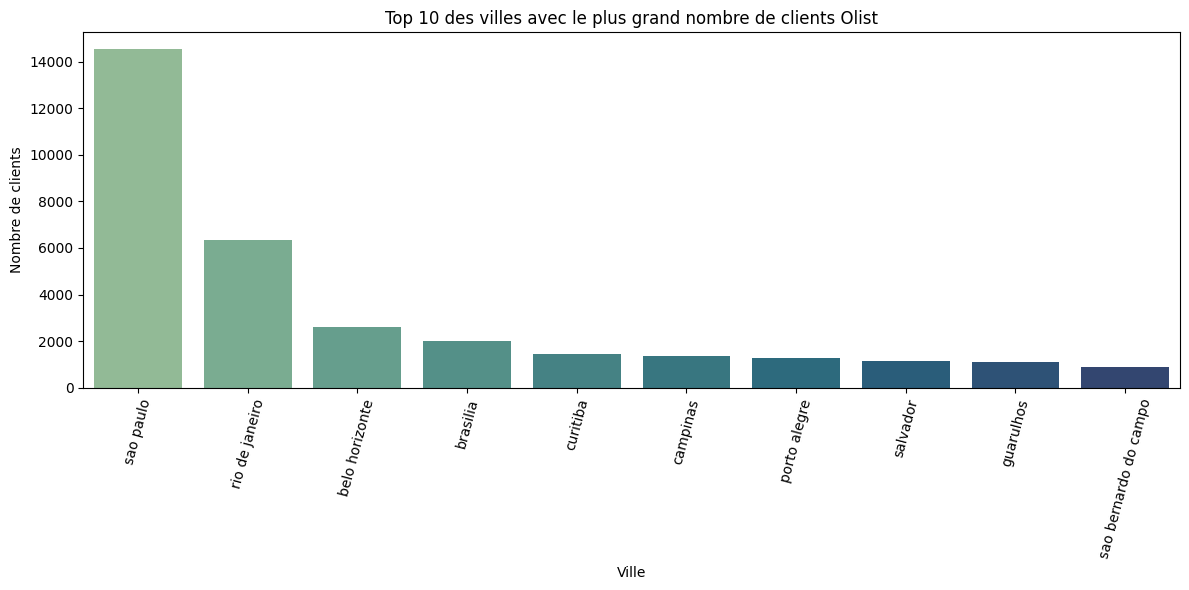

In [10]:
# Répartition des clients par ville du Brésil
distribution = df[['customer_city', 'customer_unique_id']].\
                        groupby(['customer_city']).agg('count').reset_index().\
                        sort_values('customer_unique_id', ascending=False)
distribution.rename(columns={'customer_unique_id': 'nombre clients'},
                    inplace=True)
print(distribution.head(n=10), "\n\n")


# Distribution of customers by city
distribution = (
    df[['customer_city', 'customer_unique_id']]
    .groupby('customer_city')
    .nunique()   # unique customers, plus pertinent
    .reset_index()
    .rename(columns={'customer_unique_id': 'nombre_clients'})
    .sort_values('nombre_clients', ascending=False)
)

# AFFICHAGE TOP 10
top_n = 10
plt.figure(figsize=(12, 6))
sns.barplot(
    data=distribution.head(top_n),
    x='customer_city',
    y='nombre_clients',
    hue='customer_city', 
    palette="crest"
)

plt.xticks(rotation=75)
plt.title("Top 10 des villes avec le plus grand nombre de clients Olist")
plt.xlabel("Ville")
plt.ylabel("Nombre de clients")
plt.tight_layout()
plt.show()


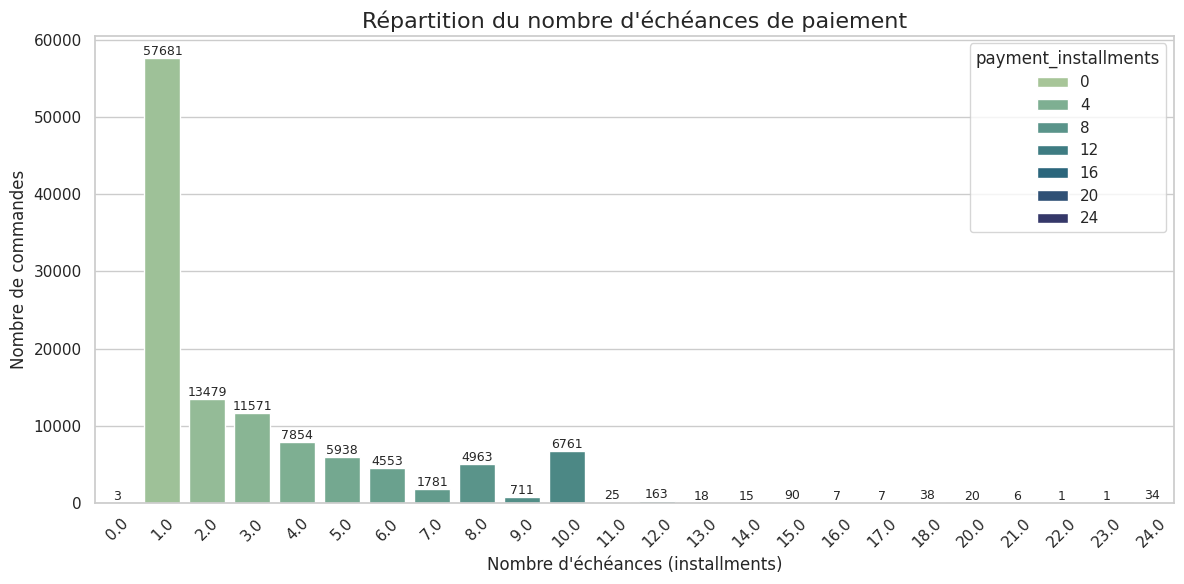

In [11]:
# Répartition des commandes selon le nombre d’échéances de paiement
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

ax = sns.countplot(
    data=df,
    x='payment_installments',
    hue='payment_installments',
    palette='crest',     # nouvelle palette plus moderne
    dodge=False
)

# Ajout des labels sur les barres
for container in ax.containers:
    ax.bar_label(container, fontsize=9)

# Titres et labels
ax.set_title("Répartition du nombre d'échéances de paiement", fontsize=16)
ax.set_xlabel("Nombre d'échéances (installments)", fontsize=12)
ax.set_ylabel("Nombre de commandes", fontsize=12)

# Rotation des labels sur l’axe X
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


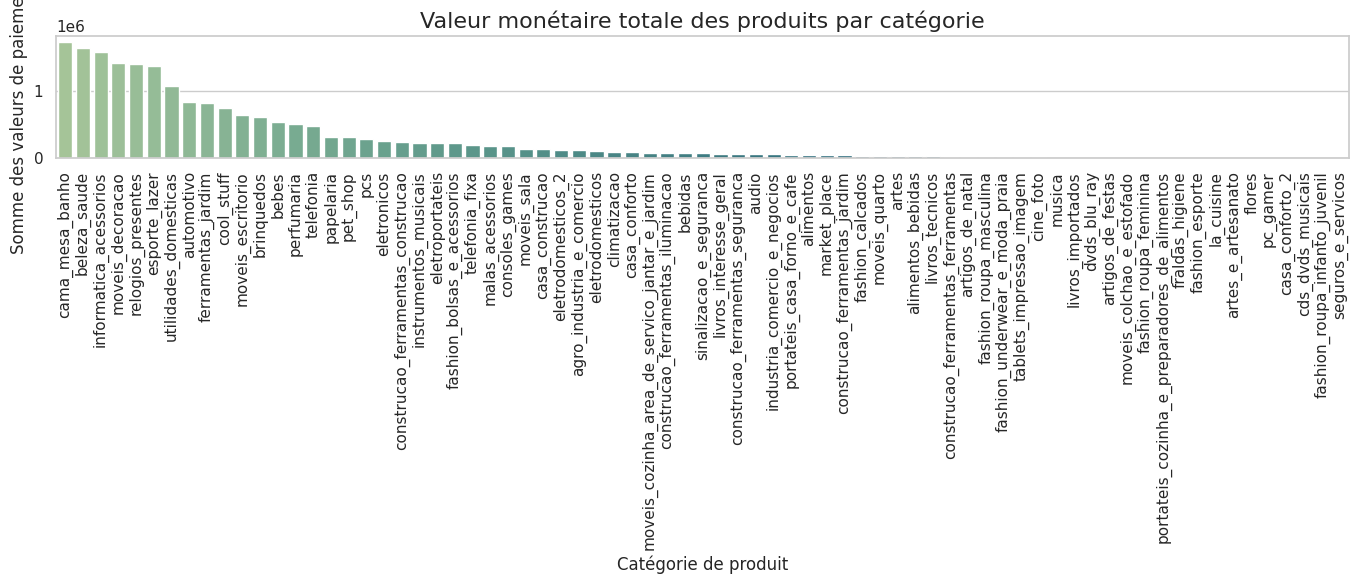

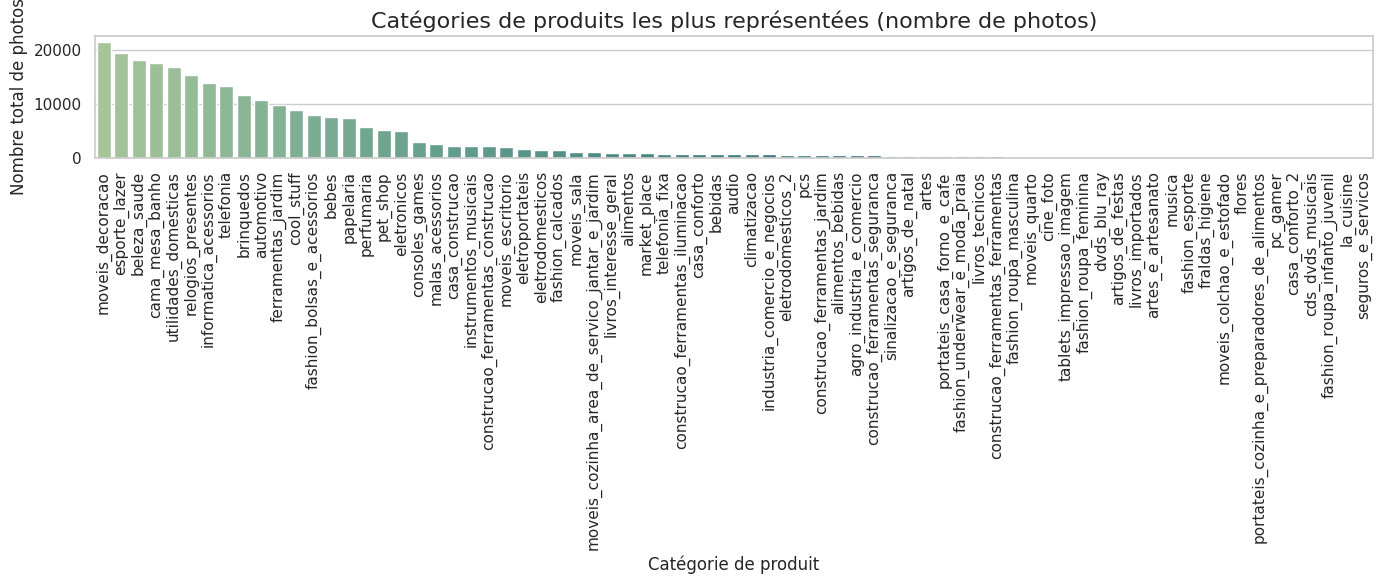

In [12]:
# Sélection des colonnes utiles
product_df  = df[["product_category_name", "payment_value"]]
product_df1 = df[["product_category_name", "product_photos_qty"]]

# Tri des catégories par valeur monétaire totale
payment_sum = (
    product_df.groupby("product_category_name").sum()
    .sort_values("payment_value", ascending=False)
)

# Tri des catégories par nombre de photos (indicateur de volume de produits)
photos_sum = (
    product_df1.groupby("product_category_name").sum()
    .sort_values("product_photos_qty", ascending=False)
)

# ==========================
# 1️⃣ Valeur monétaire totale par catégorie
# ==========================
plt.figure(figsize=(14, 6))
sns.barplot(
    x=payment_sum.index,
    y=payment_sum["payment_value"],
    hue=payment_sum.index,
    palette="crest"      # 🎨 Nouvelle palette moderne
)
plt.xticks(rotation=90)
plt.title("Valeur monétaire totale des produits par catégorie", fontsize=16)
plt.ylabel("Somme des valeurs de paiement (R$)")
plt.xlabel("Catégorie de produit")
plt.tight_layout()
plt.show()

# ==========================
# 2️⃣ Catégories les plus représentées via nombre de photos
# ==========================
plt.figure(figsize=(14, 6))
sns.barplot(
    x=photos_sum.index,
    y=photos_sum["product_photos_qty"],
    hue=photos_sum.index,
    palette="crest"         # 🎨 Palette différente pour contraste
)
plt.xticks(rotation=90)
plt.title("Catégories de produits les plus représentées (nombre de photos)", fontsize=16)
plt.ylabel("Nombre total de photos")
plt.xlabel("Catégorie de produit")
plt.tight_layout()
plt.show()

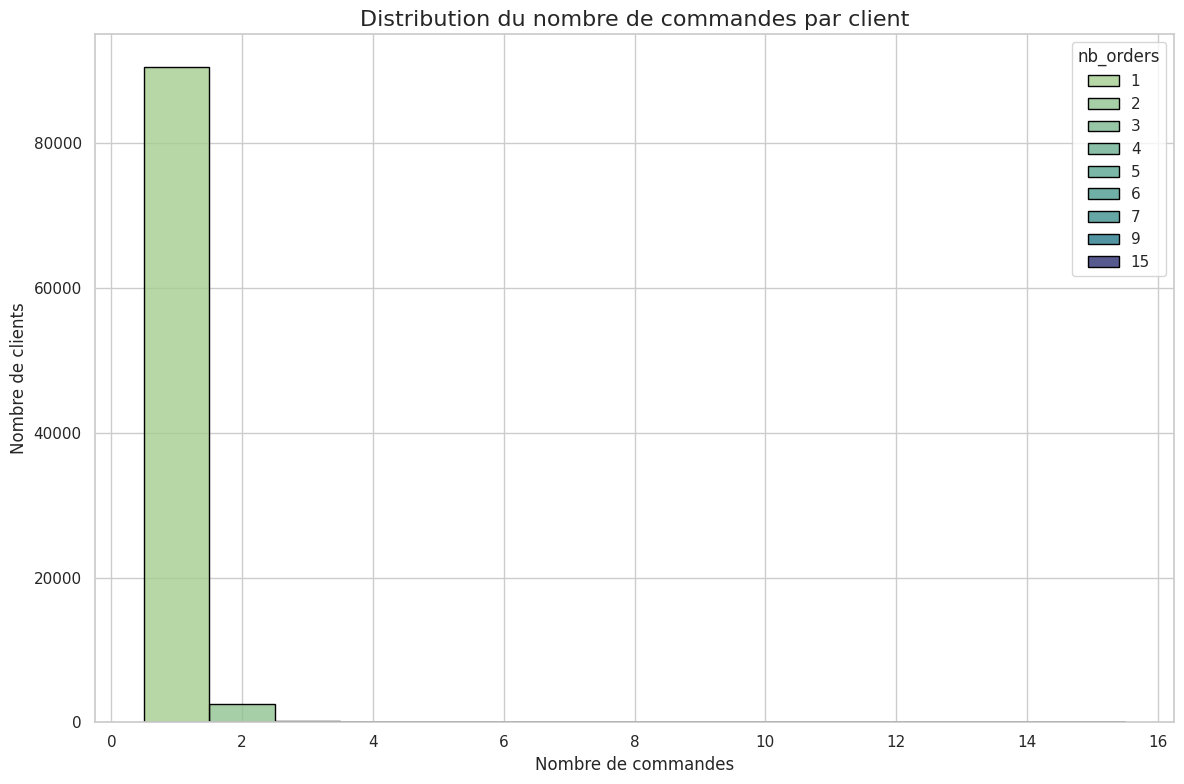

In [18]:
# Calcul du nombre de commandes par client
orders_per_customer = (
    df.groupby("customer_unique_id")["order_id"]
    .nunique()
    .reset_index(name="nb_orders")
)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Utilisation d'une palette moderne (ex: "mako", "crest", "viridis")
sns.histplot(
    data=orders_per_customer,
    x="nb_orders",
    hue="nb_orders",
    discrete=True,
    edgecolor="black",
    palette="crest",   # 🎨 Palette moderne
    alpha=0.8)

plt.xlabel("Nombre de commandes", fontsize=12)
plt.ylabel("Nombre de clients", fontsize=12)
plt.title("Distribution du nombre de commandes par client", fontsize=16)
plt.tight_layout()
plt.show()


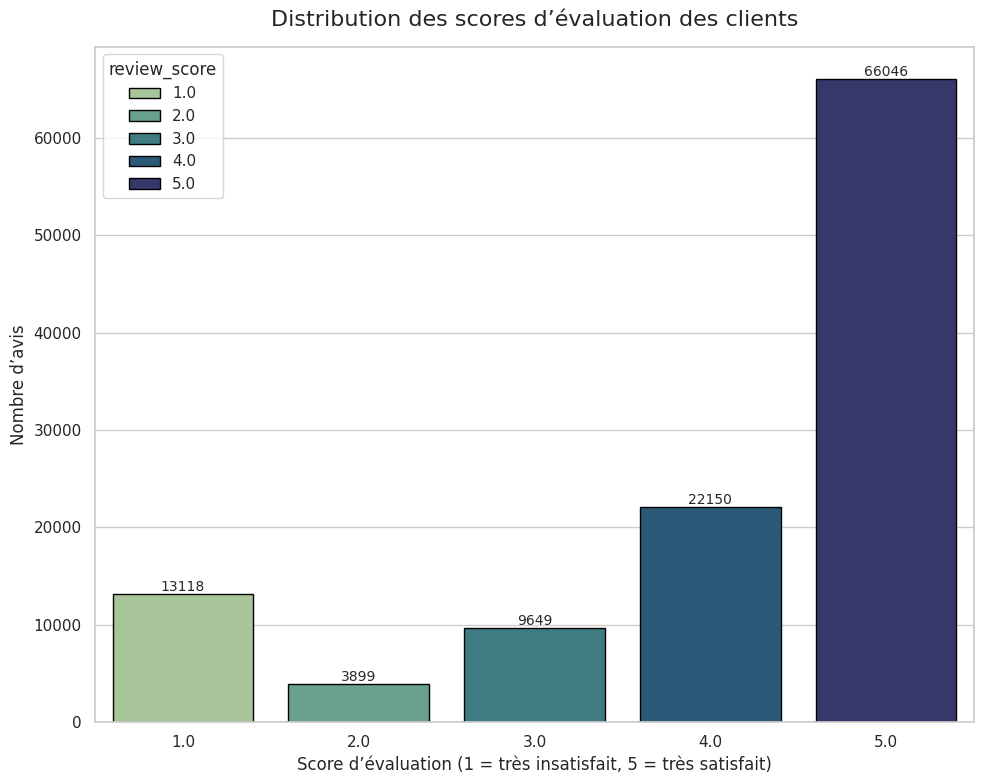

In [19]:
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

ax = sns.countplot(
    x='review_score',
    hue='review_score',
    data=df,
    palette='crest',     # 🎨 Palette moderne au lieu d'une couleur fixe
    edgecolor="black"
)

# Ajout des labels sur chaque barre
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Titre amélioré
ax.set_title("Distribution des scores d’évaluation des clients", fontsize=16, pad=15)

# Labels des axes
ax.set_xlabel("Score d’évaluation (1 = très insatisfait, 5 = très satisfait)", fontsize=12)
ax.set_ylabel("Nombre d’avis", fontsize=12)

plt.tight_layout()
plt.show()


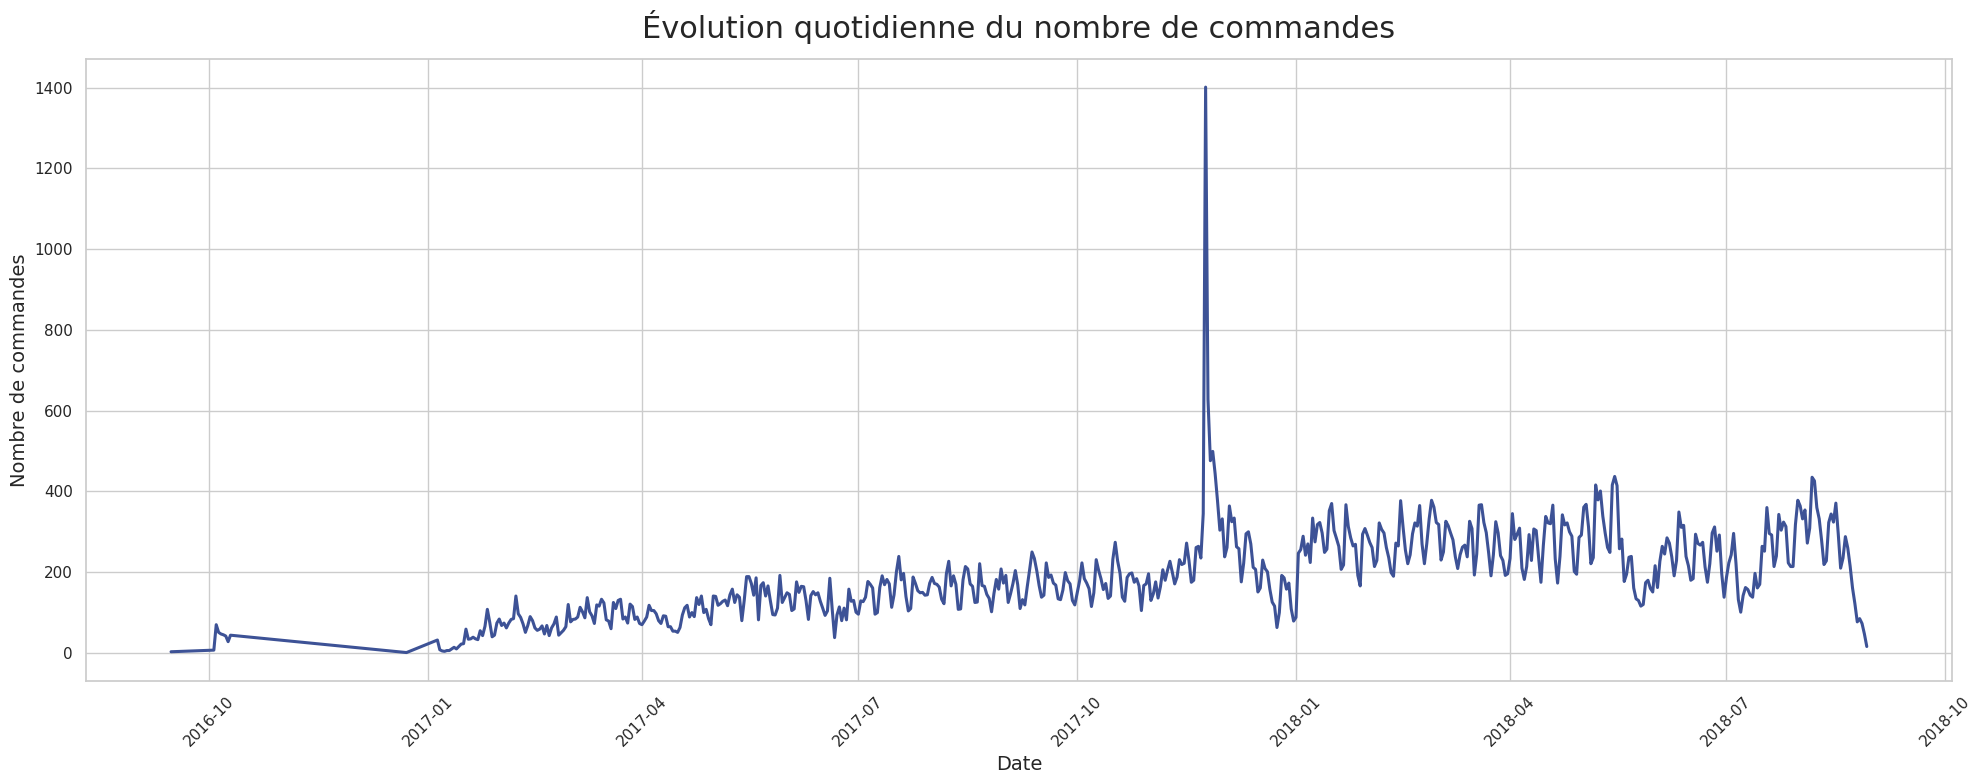

In [20]:
# Agrégation du nombre de commandes par jour
orders_per_days = (
    df.groupby(df["order_purchase_timestamp"].dt.date)["order_id"]
    .count()
)

plt.figure(figsize=(20, 8))
sns.set(style="whitegrid")

# Utilisation d'une palette moderne (ex : crest, viridis, mako)
ax = sns.lineplot(
    x=orders_per_days.index,
    y=orders_per_days.values,
    color=sns.color_palette("mako", 10)[3],     # Couleur plus élégante
    linewidth=2.2
)

# Titres et labels améliorés
ax.set_title("Évolution quotidienne du nombre de commandes", fontsize=22, pad=15)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Nombre de commandes", fontsize=14)

# Rotation des dates
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_8280/196711005.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["order_id"]


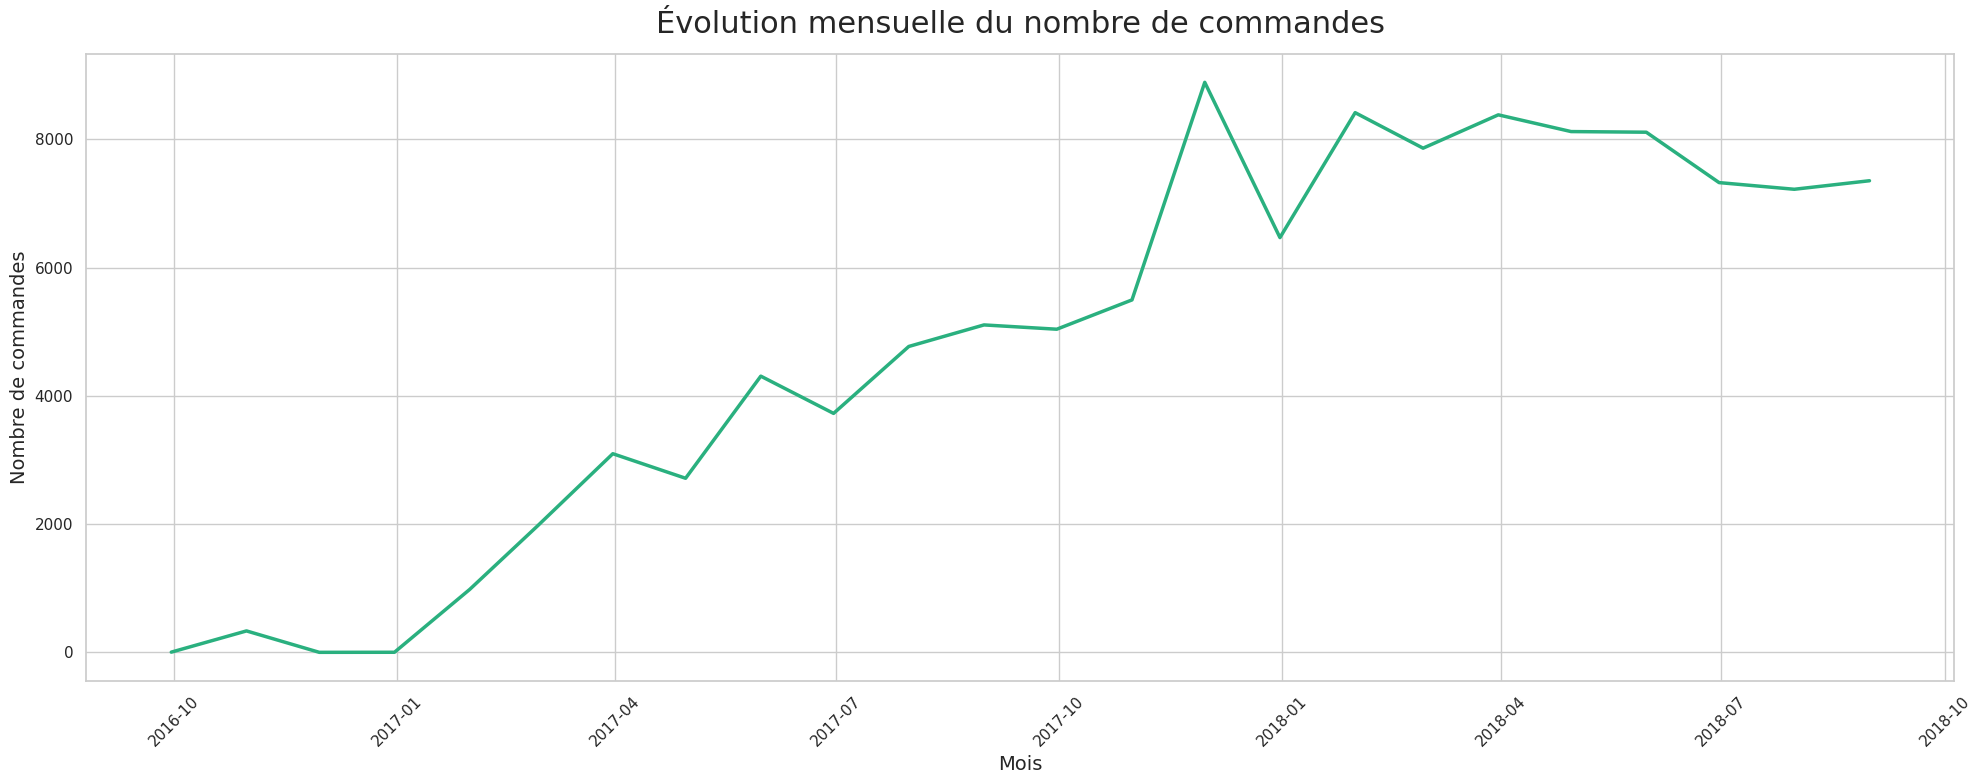

In [21]:
# Conversion explicite en datetime si nécessaire
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

# Agrégation par mois
orders_per_month = (
    df
    .set_index("order_purchase_timestamp")
    .resample("M")["order_id"]
    .count()
)

plt.figure(figsize=(20, 8))
sns.set(style="whitegrid")

# Tracé avec palette moderne
ax = sns.lineplot(
    x=orders_per_month.index,
    y=orders_per_month.values,
    color=sns.color_palette("viridis", 10)[6],  # 🎨 Couleur élégante
    linewidth=2.5
)

# Titres et labels améliorés
ax.set_title("Évolution mensuelle du nombre de commandes", fontsize=22, pad=15)
ax.set_xlabel("Mois", fontsize=14)
ax.set_ylabel("Nombre de commandes", fontsize=14)

# Rotation des dates
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


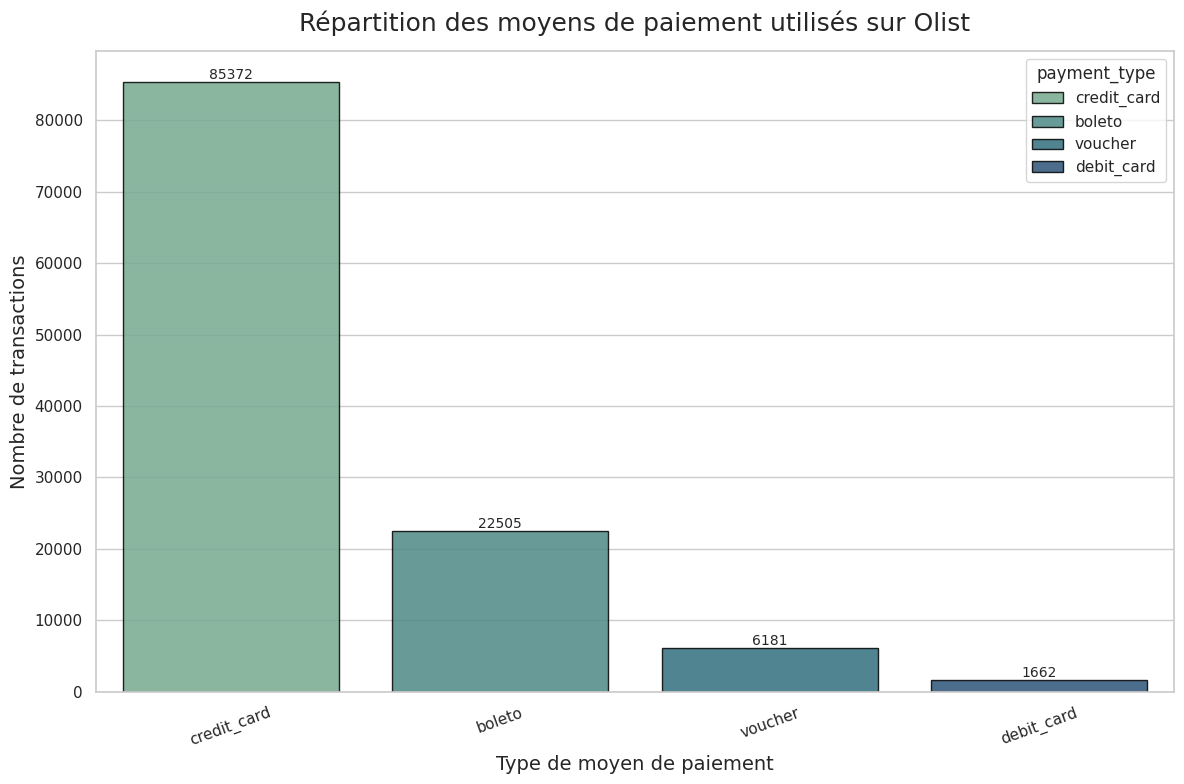

In [22]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

ax = sns.countplot(
    data=df,
    x="payment_type",
    hue="payment_type",
    palette="crest",     # Palette moderne
    edgecolor="black",
    alpha=0.85
)

# Ajouter les valeurs au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Titre amélioré
ax.set_title("Répartition des moyens de paiement utilisés sur Olist", 
             fontsize=18, pad=15)

# Labels des axes
ax.set_xlabel("Type de moyen de paiement", fontsize=14)
ax.set_ylabel("Nombre de transactions", fontsize=14)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()